# NLP Project 1: Compositionality
Authors: Tom Lotze (11161159) & Berend Jansen (11051949)

## Instructions for running
- Make sure the that the *data/* and *PCFG/* folders are in the current working directory. The OpenNMT github will be cloned as well.
- Data is generated using seperate python scripts. The general data (including training set) is generated by PCFG.py, the specific test sets are generated by other PCFG python scripts.
- All data and model paths will be created automatically. There are a lot, since we trained 2 * 3 models and have various test sets. Run the cells in sequential manner to ensure all variables later on are defined. 
- The following happens, in this order, this can also be seen in the table of contents. **Note:** The models are too large to be handed in, but all source, target and prediction files are handed in, so all results can be reproduced.
    - The data is preprocessed, and the vocabulary is printed as a sanity test
    - The LSTM and Transformer models are trained and saved/ The LSTM model is often referred to in code as "basic" model
    - The general performance is evaluated on the test set and the best model is kept for the other experiments. This is the first LSTM model and the second (medium) Transformer model. 
    - Then, some general properties of the data are investigated, such as length, relative error of operators etc. 
    - Substitutivity experiment on clean and complete dataset
    - Localism experiment, additive localism first and sequential localism second. 

- Finally, sample code for generating attention plots is shown at the bottom of the notebook

If there are additional questions, you can reach us via Slack or email: tom.lotze@gmail.com / berend.Jansen1@student.auc.nl






In [ ]:
from google.colab import drive
drive.mount('Drive/')


Drive already mounted at Drive/; to attempt to forcibly remount, call drive.mount("Drive/", force_remount=True).


In [ ]:
# make sure to be in the project folder, where ./data/ and ./PCFG/ are available.
import os
os.chdir('Drive/My Drive/Project_1')
os.getcwd()

'/content/Drive/My Drive/Project_1'

## Clone the OpenNMT git repo

In [ ]:
# Execute only once
!git clone https://github.com/OpenNMT/OpenNMT-py

## Import libraries
Make sure torchtext is version 0.4.0

In [ ]:
%%capture
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import re
!pip install OpenNMT-py


## Helper functions

In [ ]:
def list_from_txt(path):
  with open(path) as f:
    targets = [i.strip() for i in f.readlines()]  
  return targets

def accuracy(source_path, targets_path, predictions_path):
  """ Implements sequence accuracy"""
  srcs = list_from_txt(source_path)
  tgts = list_from_txt(targets_path)
  preds = list_from_txt(predictions_path)
  assert len(tgts) == len(preds), "Targets and predictions are not the same length"

  length = len(preds)
  errors = [(src, i, j) for i, j, src in zip(preds, tgts, srcs) if i != j]

  acc = (length - len(errors)) / length

  return acc, errors


In [ ]:
# set data variables
model_name = "26term_-1max"
datadir = f"data/{model_name}/"
save_dir = datadir + model_name
model_folder_basic = datadir + "model/basic/"
model_folder_transformer = datadir + "model/transformer/"

# create model folders
os.makedirs(model_folder_basic, exist_ok=True)
os.makedirs(model_folder_transformer, exist_ok=True)

# create data paths
src_train_path = datadir + "train_src.txt"
tgt_train_path = datadir + "train_tgt.txt"

src_valid_path = datadir + "valid_src.txt"
tgt_valid_path = datadir + "valid_tgt.txt"

src_test_path = datadir + "test_src.txt"
tgt_test_path = datadir + "test_tgt.txt"

# create model paths
basic_model_path = model_folder_basic + "basic"
basic_model_path2 = model_folder_basic + "basic2"
basic_model_path3 = model_folder_basic + "basic3"

transformer_model_path = model_folder_transformer + "transformer"
transformer_model_path2 = model_folder_transformer + "transformer_2"
transformer_model_path3 = model_folder_transformer + "transformer_3"

# Data Generation
All data used will be generated by the pcfg scripts below. It is not necessary to actually run them, as all preprocessed data is already handed in.

Note that the specific test datasets are generated slower, as the requirements for the sequences are stricter.

In [ ]:
!python PCFG/PCFG.py 
!python PCFG/PCFG_sub_clean.py
!python PCFG/PCFG_sub_complete.py
!python PCFG/PCFG_local.py
!python PCFG/PCFG_sequential_local.py

# Preprocessing



In [ ]:
!python ./OpenNMT-py/preprocess.py \
        -train_src $src_train_path \
        -train_tgt $tgt_train_path \
        -valid_src $src_valid_path \
        -valid_tgt $tgt_valid_path \
        -save_data $save_dir 

## Vocabulary

In [ ]:

vocab_fields = torch.load(f"{save_dir}.vocab.pt")
print(vocab_fields["src"].base_field.vocab.stoi.items())
print(vocab_fields["tgt"].base_field.vocab.stoi.items())

dict_items([('<unk>', 0), ('<blank>', 1), ('SHIFT', 2), ('+', 3), ('B1', 4), ('F3', 5), ('@', 6), ('#', 7), ('B3', 8), ('B2', 9), ('F1', 10), ('F2', 11), ('R', 12), ('b', 13), ('a', 14), ('q', 15), ('v', 16), ('u', 17), ('j', 18), ('o', 19), ('n', 20), ('g', 21), ('y', 22), ('l', 23), ('k', 24), ('w', 25), ('m', 26), ('t', 27), ('h', 28), ('c', 29), ('i', 30), ('x', 31), ('z', 32), ('s', 33), ('e', 34), ('d', 35), ('p', 36), ('r', 37), ('f', 38)])
dict_items([('<unk>', 0), ('<blank>', 1), ('<s>', 2), ('</s>', 3), ('h', 4), ('b', 5), ('j', 6), ('v', 7), ('a', 8), ('t', 9), ('q', 10), ('l', 11), ('e', 12), ('o', 13), ('u', 14), ('y', 15), ('p', 16), ('s', 17), ('k', 18), ('c', 19), ('g', 20), ('d', 21), ('n', 22), ('w', 23), ('r', 24), ('i', 25), ('f', 26), ('x', 27), ('z', 28), ('m', 29)])


# Training

## LSTM Model (Basic)

In [ ]:
!python OpenNMT-py/train.py \
        -data $save_dir \
        -save_model $basic_model_path1 \
        -train_steps 50000 
        -gpu_ranks 0

## LSTM 2

In [ ]:
!python OpenNMT-py/train.py\
        -data $save_dir\
        -save_model $basic_model_path2 \
        -layers 3 \
        -rnn_size 300 \
        -train_steps 50000 \
        -gpu_ranks 0

## LSTM 3

In [ ]:
!python OpenNMT-py/train.py \
        -data $save_dir \
        -save_model $basic_model_path3 \
        -layers 4\
        -rnn_size 400\
        -train_steps 50000 \
        -gpu_ranks 0

## Large Transformer model (1)

In [ ]:
!python OpenNMT-py/train.py -data $save_dir \
                            -save_model $transformer_model_path \
                            -layers 6 \
                            -rnn_size 512 \
                            -word_vec_size 512 \
                            -transformer_ff 2048 \
                            -heads 8 \
                            -encoder_type transformer \
                            -decoder_type transformer \
                            -position_encoding \
                            -train_steps 10000 \
                            -max_generator_batches 2 \
                            -dropout 0.1 \
                            -batch_size 4096 \
                            -batch_type tokens \
                            -normalization tokens \
                            -accum_count 2 \
                            -optim adam \
                            -adam_beta2 0.998 \
                            -decay_method noam \
                            -warmup_steps 8000 \
                            -learning_rate 2 \
                            -max_grad_norm 0 \
                            -param_init 0 \
                            -param_init_glorot \
                            -label_smoothing 0.1 \
                            -valid_steps 1000 \
                            -save_checkpoint_steps 1000 \
                            -world_size 1 \
                            -gpu_rank 0

## Medium Transformer model (2)

In [ ]:
# changed: layers, warmup steps, train steps, 
!python OpenNMT-py/train.py -data $save_dir \
                            -save_model $transformer_model_path2 \
                            -layers 4 \
                            -rnn_size 512 \
                            -word_vec_size 512 \
                            -transformer_ff 2048 \
                            -heads 8 \
                            -encoder_type transformer \
                            -decoder_type transformer \
                            -position_encoding \
                            -train_steps 30000 \
                            -max_generator_batches 2 \
                            -dropout 0.1 \
                            -batch_size 64 \
                            -accum_count 2 \
                            -optim adam \
                            -adam_beta2 0.998 \
                            -decay_method noam \
                            -warmup_steps 5000 \
                            -learning_rate 0.5 \
                            -max_grad_norm 0 \
                            -param_init 0 \
                            -param_init_glorot \
                            -label_smoothing 0.1 \
                            -valid_steps 2000 \
                            -save_checkpoint_steps 2000 \
                            -world_size 1 \
                            -gpu_rank 0

## Small Transformer model (3)

In [ ]:
# changed: rnn_size, word_vec_size, dropout

!python OpenNMT-py/train.py -data $save_dir \
                            -save_model $transformer_model_path3 \
                            -layers 4 \
                            -rnn_size 256 \
                            -word_vec_size 256 \
                            -transformer_ff 2048 \
                            -heads 8 \
                            -encoder_type transformer \
                            -decoder_type transformer \
                            -position_encoding \
                            -train_steps 30000 \
                            -max_generator_batches 2 \
                            -dropout 0.3 \
                            -batch_size 64 \
                            -accum_count 2 \
                            -optim adam \
                            -adam_beta2 0.998 \
                            -decay_method noam \
                            -warmup_steps 5000 \
                            -learning_rate 0.5 \
                            -max_grad_norm 0 \
                            -param_init 0 \
                            -param_init_glorot \
                            -label_smoothing 0.1 \
                            -valid_steps 2000 \
                            -save_checkpoint_steps 2000 \
                            -world_size 1 \
                            -gpu_rank 0


# General performance


## LSTM

### Predictions on test set

In [ ]:
# set paths for models and predictions on test set
basic_model = basic_model_path + "_step_45000.pt"
basic_pred_path = basic_model_path + "_pred.txt"

basic_model2 = basic_model_path2 + "_step_50000.pt"
basic_pred_path2 = basic_model_path2 + "_pred.txt"

basic_model3 = basic_model_path3 + "_step_50000.pt"
basic_pred_path3 = basic_model_path3 + "_pred.txt"

In [ ]:
# get predictions for basic model
# 45000 scores the best with an accuracy of 0.9046
#!python OpenNMT-py/translate.py -model $basic_model -src $src_test_path -output $basic_pred_path  -replace_unk -gpu 0

In [ ]:
# get predictions for basic model 2
!python OpenNMT-py/translate.py -model $basic_model2 -src $src_test_path -output $basic_pred_path2  -replace_unk -gpu 0

[2020-04-20 14:40:55,126 INFO] Translating shard 0.
PRED AVG SCORE: -0.2020, PRED PPL: 1.2238


In [ ]:
# get predictions for basic model 3
!python OpenNMT-py/translate.py -model $basic_model3 -src $src_test_path -output $basic_pred_path3  -replace_unk -gpu 0

[2020-04-20 15:59:01,281 INFO] Translating shard 0.
PRED AVG SCORE: -1.6501, PRED PPL: 5.2072


### Sequence accuracy on test set

Accuracies on test set is computed here, errors can be inspected by uncommenting the print statements

In [ ]:
# print results for basic model on test set
basic_acc1, basic_errors1 = accuracy(src_test_path, tgt_test_path, basic_pred_path)
print(basic_acc1)
# print(*basic_errors1, sep="\n")

0.9046


In [ ]:
# print results for basic model on test set
basic_acc2, basic_errors2 = accuracy(src_test_path, tgt_test_path, basic_pred_path2)
print(basic_acc2)
# print(*basic_errors2[:5], sep="\n")

In [ ]:
# print results for basic model on test set
basic_acc3, basic_errors3 = accuracy(src_test_path, tgt_test_path, basic_pred_path3)
print(basic_acc3)
# print(*basic_errors3, sep="\n")

0.3504


## Transformer


### Predictions on test set 


In [ ]:
# set paths for predictions and best transformer models
transformer_model1 = transformer_model_path + "_step_30000.pt"
transformer_pred_path1 = transformer_model_path + "_pred.txt"

transformer_model2 = transformer_model_path2 + "_step_30000.pt"
transformer_pred_path2 = transformer_model_path2 + "_pred.txt"

transformer_model3 = transformer_model_path3 + "_step_30000.pt"
transformer_pred_path3 = transformer_model_path3 + "_pred.txt"

In [ ]:
# get predictions for large transformer model
!python OpenNMT-py/translate.py -model $transformer_model -src $src_test_path -output $transformer_pred_path -replace_unk

In [ ]:
# get predictions for small transformer model
!python OpenNMT-py/translate.py -model $transformer_model2 -src $src_test_path -output $transformer_pred_path2 -replace_unk

In [ ]:
# get predictions for small transformer model
!python OpenNMT-py/translate.py -model $transformer_model3 -src $src_test_path -output $transformer_pred_path3 -replace_unk

### Sequence accuracy on test set

In [ ]:
# print results for large transformer model on test set
trans_acc1, trans_errors1 = accuracy(src_test_path, tgt_test_path, transformer_pred_path1)
print(trans_acc1)

0.8963


In [ ]:
# print results for medium transformer model on test set
trans_acc2, trans_errors2 = accuracy(src_test_path, tgt_test_path, transformer_pred_path2)
print(trans_acc2)

0.9028


In [ ]:
# print results for small transformer model on test set
trans_acc3, trans_errors3 = accuracy(src_test_path, tgt_test_path, transformer_pred_path3)
print(trans_acc3)

0.7785


# General performance & Data Properties

In [ ]:
def counter_(list_of_operators):
    """Compute the frequency of operators from a list"""
    nr_tokens = len(list_of_operators)
    c = Counter(list_of_operators)
    counter_relative = {k:[v, np.round((v/nr_tokens)*100, 2)]  for k, v in c.most_common()}

    return counter_relative

## All data properties


nr sequences 100000
{'+': 75840, 'SHIFT': 73984, 'B1': 56424, 'F3': 55991, 'B3': 55824, '@': 55742, '#': 55686, 'F2': 55655, 'B2': 55649, 'F1': 55488, 'R': 55339}
num operators total 651622


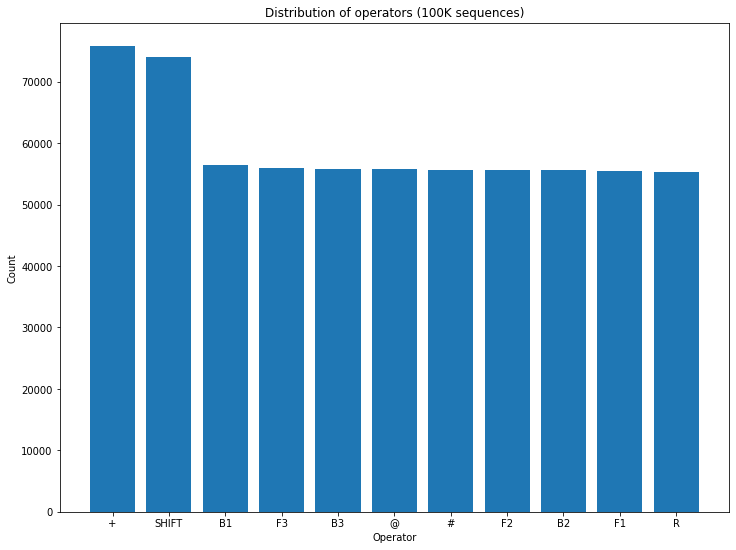

In [ ]:
# Get a histogram of the operator frequencies in the training set
all_data_path = "./data/26term_-1max/ALL.txt"
with open(all_data_path) as f:
  seqs = [s.strip().split() for s in f.readlines()]
  print("nr sequences:", len(seqs))

operator_list_all = [i for seq in seqs for i in seq if not i.islower()]

count = counter_(operator_list_all)
absolute_counter = {k:v[0] for k, v in count.items()}
print(absolute_counter)
print("num operators total:", sum(absolute_counter.values()))

plt.figure(figsize=(12,9))
plt.bar(list(absolute_counter.keys()), list(absolute_counter.values()))
plt.xlabel("Operator")
plt.ylabel("Count")
plt.title("Distribution of operators (100K sequences)")
plt.show()

## Length - Accuracy

In [ ]:
def acc_len(source_path, targets_path, predictions_path):
  """ Computes the average accuracy per lengths for the sequences"""
  srcs = list_from_txt(source_path)
  tgts = list_from_txt(targets_path)
  preds = list_from_txt(predictions_path)
  assert len(tgts) == len(preds), "Targets and predictions are not the same length"

  # compute the accuracy per length
  source_lens = Counter([len(s.split()) for s in srcs])
  wrong_lens = Counter([len(src.split()) for i, j, src in zip(preds, tgts, srcs) if i != j])
  lens = sorted(source_lens.keys())
  acc_per_length = {k:(source_lens[k]- wrong_lens[k])/source_lens[k] for k in lens if source_lens[k]>5}
  
  return acc_per_length, source_lens


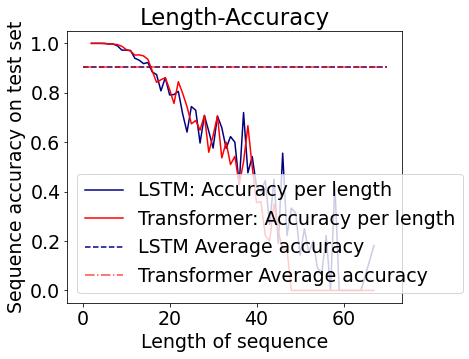

In [ ]:
# Create length-accuracy plot
matplotlib.rcParams.update({'font.size': 19})
# best LSTM model length-accuracy:
acc_per_len_basic, _i10 = acc_len(src_test_path, tgt_test_path, basic_pred_path)
# best TRANSFORMER model length-accuracy:
acc_per_len_trans, _ = acc_len(src_test_path, tgt_test_path, transformer_pred_path2)

plt.figure(figsize=(12, 10))
plt.plot(list(acc_per_len_basic.keys()), list(acc_per_len_basic.values()), color="navy", label="LSTM: Accuracy per length")
plt.hlines(basic_acc1, 0, 70, colors="navy", linestyles="dashed", label="LSTM Average accuracy")
plt.plot(list(acc_per_len_trans.keys()), list(acc_per_len_trans.values()), color="r", label="Transformer: Accuracy per length")
plt.hlines(trans_acc2, 0, 70, colors="r", linestyles= "dashdot", label="Transformer Average accuracy",alpha=0.7)
plt.xlabel("Length of sequence")
plt.ylabel("Sequence accuracy on test set")
plt.title("Length-Accuracy")
plt.legend(loc=3)
plt.show()



12.339082352941176 12.888224889603018
12.5847 13.357463303711526
12.35852 12.90968641794215


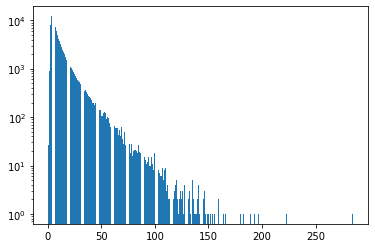

In [ ]:
# compute average lengths of all datasets
def avg_seq_len(txt_path):
    """ Computes the mean length and standard deviation of a dataset """
    with open(txt_path) as f:
        lengths = [len(s.strip().split()) for s in f.readlines()]
    return np.mean(lengths), np.std(lengths)

avg_train_len, std_train_len = avg_seq_len(src_train_path)
avg_test_len, std_test_len = avg_seq_len(src_test_path)
avg_all_len, std_all_len = avg_seq_len(all_data_path)

# Average lengths of training, tes, and all combined
print(avg_train_len, std_train_len)
print(avg_test_len, std_test_len)
print(avg_all_len, std_all_len)


with open(src_test_path) as f:
  lengths = [len(s.strip().split()) for s in f.readlines()]
c = Counter(lengths)
x = sorted(list(c.keys()))
y = [c[i] for i in x]

plt.figure()
plt.bar(x, y)
plt.show()

### LSTM




In [ ]:
# compute relative frequencies of operators in wrongly predicted sequences for the LSTM model
basic_errors_seq = [i[0] for i in basic_errors1]
print("number of errors", len(basic_errors_seq))
lol_operators = [string.split() for string in basic_errors_seq]
operator_list_basic = [i for seq in lol_operators for i in seq if not i.islower()]

count = counter_(operator_list_basic)
absolute_counter = {k:v[0] for k, v in count.items()}

plt.figure()
plt.bar(list(absolute_counter.keys()), list(absolute_counter.values()))
plt.xlabel("Operator")
plt.ylabel("Count")
plt.title("Distribution of operators in errors of LSTM ()")
plt.show()

In [ ]:
# compute the average length of the wrongly predicted samples
basic_lengths = [len(seq.split()) for seq in basic_errors_seq]
avg_basic_len, std_basic_len = np.mean(basic_lengths), np.std(basic_lengths)
print("average", avg_basic_len, "std", std_basic_len)

37.79454926624738 24.13692013670609


### Transformer

In [ ]:
# compute relative frequencies of operators in wrongly predicted sequences
trans_errors_seq = [i[0] for i in trans_errors]
lol_operators = [string.split() for string in trans_errors_seq]
operator_list_trans = [i for seq in lol_operators for i in seq if not i.islower()]

count = counter_(operator_list_trans)
print(count)

{'+': [3143, 14.8], 'SHIFT': [2432, 11.45], 'F3': [1803, 8.49], '@': [1784, 8.4], 'F2': [1756, 8.27], 'B3': [1751, 8.24], 'R': [1739, 8.19], 'B1': [1734, 8.16], 'B2': [1705, 8.03], 'F1': [1701, 8.01], '#': [1695, 7.98]}


In [ ]:
# compute the average length of the wrongly predicted samples
trans_lengths = [len(seq.split()) for seq in trans_errors_seq]
avg_trans_len, std_trans_len = np.mean(trans_lengths), np.std(trans_lengths)
print("average", avg_trans_len, "std", std_trans_len)

37.8784956605593 23.57741696202096


# Compositionality test 1: Substituitivity

In [ ]:
def consistency(pred_path1, pred_path2, target_path = None):
  """
  Returns the consistency in predictions between 2 sets of predictions, and 
  saves the inconsistent predictions in a list. If a target set is given, the 
  correct target will also be added in the list. If no target is given, the 
  index is put instead.
  """

  # open the files
  with open(pred_path1) as f:
    predictions1 = [s.strip() for s in f.readlines()]
  with open(pred_path2) as f:
    predictions2 = [s.strip() for s in f.readlines()]
  if target_path:
    with open(target_path) as f:
      targets = [s.strip() for s in f.readlines()]
  else:
    targets = None

  assert len(predictions1) == len(predictions2)

  # loop over the two sets of predictions and check if they correspond
  count = 0 
  inconsistencies = [] 
  if targets:
    for (s1, s2, t) in zip(predictions1, predictions2, targets):
      if s1==s2:
        count += 1  
      else:
        inconsistencies.append([t, s1, s2])
  else:
    for i, (s1, s2) in enumerate(zip(predictions1, predictions2)):
      if s1==s2:
        count += 1  
      else:
        inconsistencies.append([i, s1, s2])
  # score is the fraction in which the two predictions corresponded
  score = count / len(predictions1)

  # inconsistencies is a lists of lists, with each sublist having the following 
  # elements: [target or index, prediction1, prediction2]

  return score, inconsistencies

## Clean data
No other operators than the shift and forward operators that we test for

In [ ]:
# define model paths
basic_model = basic_model_path + "_step_45000.pt"
transformer_model2 = transformer_model_path2 + "_step_30000.pt"

# define data and prediction paths
sub_clean = "./data/substitutivity/clean/"
data_clean_unary_path = sub_clean + "src_unary.txt"
data_clean_binary_path = sub_clean + "src_binary.txt"
data_clean_TGT_path = sub_clean + "TGT.txt"
basic_clean_unary_pred_path = sub_clean + "basic_pred_unary_clean.txt"
basic_clean_binary_pred_path = sub_clean + "basic_pred_binary_clean.txt"
trans_clean_unary_pred_path = sub_clean + "trans_pred_unary_clean.txt"
trans_clean_binary_pred_path = sub_clean + "trans_pred_binary_clean.txt"

In [ ]:
# translate basic model
!python OpenNMT-py/translate.py -model $basic_model -src $data_clean_unary_path -output $basic_clean_unary_pred_path  -replace_unk -gpu 0
!python OpenNMT-py/translate.py -model $basic_model -src $data_clean_binary_path -output $basic_clean_binary_pred_path  -replace_unk -gpu 0

# translate transformer model
!python OpenNMT-py/translate.py -model $transformer_model2 -src $data_clean_unary_path -output $trans_clean_unary_pred_path  -replace_unk -gpu 0
!python OpenNMT-py/translate.py -model $transformer_model2 -src $data_clean_binary_path -output $trans_clean_binary_pred_path  -replace_unk -gpu 0

[2020-04-20 11:55:24,402 INFO] Translating shard 0.
PRED AVG SCORE: -0.0100, PRED PPL: 1.0101
[2020-04-20 11:56:18,108 INFO] Translating shard 0.
PRED AVG SCORE: -0.0198, PRED PPL: 1.0200
[2020-04-20 11:57:13,574 INFO] Translating shard 0.
PRED AVG SCORE: -0.1186, PRED PPL: 1.1259
[2020-04-20 11:59:11,340 INFO] Translating shard 0.
PRED AVG SCORE: -0.1332, PRED PPL: 1.1425


### Accuracy clean

In [ ]:
basic_acc_unary_clean, _ = accuracy(data_clean_unary_path, data_clean_TGT_path, basic_clean_unary_pred_path)
basic_acc_binary_clean, _ = accuracy(data_clean_binary_path, data_clean_TGT_path, basic_clean_binary_pred_path)
trans_acc_unary_clean, _ = accuracy(data_clean_unary_path, data_clean_TGT_path, trans_clean_unary_pred_path)
trans_acc_binary_clean, _ = accuracy(data_clean_binary_path, data_clean_TGT_path, trans_clean_binary_pred_path)

print(basic_acc_unary_clean, trans_acc_unary_clean) 
print(basic_acc_binary_clean, trans_acc_binary_clean)

0.9784 0.9633
0.7678 0.9471


### Consistency clean

In [ ]:
len(incons_trans_clean)

486

In [ ]:
consistency_basic_clean, incons_basic_clean = consistency(basic_clean_unary_pred_path, basic_clean_binary_pred_path, data_clean_TGT_path)
consistency_trans_clean, incons_trans_clean = consistency(trans_clean_unary_pred_path, trans_clean_binary_pred_path, data_clean_TGT_path)
print(f"consistency basic clean: {consistency_basic_clean}")
print(f"consistency transformer clean: {consistency_trans_clean}")


consistency basic clean: 0.7671
consistency transformer clean: 0.9514


## Complete Data

In [ ]:
sub_complete = "./data/substitutivity/complete/"
data_complete_unary_path = sub_complete + "src_unary.txt"
data_complete_binary_path = sub_complete + "src_binary.txt"
data_complete_TGT_path = sub_complete + "TGT.txt"
basic_complete_unary_pred_path = sub_complete + "basic_pred_unary_complete.txt"
basic_complete_binary_pred_path = sub_complete + "basic_pred_binary_complete.txt"
trans_complete_unary_pred_path = sub_complete + "trans_pred_unary_complete.txt"
trans_complete_binary_pred_path = sub_complete + "trans_pred_binary_complete.txt"

In [ ]:
# translate basic model
!python OpenNMT-py/translate.py -model $basic_model -src $data_complete_unary_path -output $basic_complete_unary_pred_path  -replace_unk -gpu 0
!python OpenNMT-py/translate.py -model $basic_model -src $data_complete_binary_path -output $basic_complete_binary_pred_path  -replace_unk -gpu 0

# translate transformer model
!python OpenNMT-py/translate.py -model $transformer_model2 -src $data_complete_unary_path -output $trans_complete_unary_pred_path  -replace_unk -gpu 0
!python OpenNMT-py/translate.py -model $transformer_model2 -src $data_complete_binary_path -output $trans_complete_binary_pred_path  -replace_unk -gpu 0

[2020-04-20 12:03:15,505 INFO] Translating shard 0.
PRED AVG SCORE: -0.0475, PRED PPL: 1.0487
[2020-04-20 12:04:17,362 INFO] Translating shard 0.
PRED AVG SCORE: -0.0528, PRED PPL: 1.0542
[2020-04-20 12:05:21,721 INFO] Translating shard 0.
PRED AVG SCORE: -0.1312, PRED PPL: 1.1402
[2020-04-20 12:07:38,786 INFO] Translating shard 0.
PRED AVG SCORE: -0.1348, PRED PPL: 1.1443


### Accuracy complete

In [ ]:
basic_acc_unary_complete, _ = accuracy(data_complete_unary_path, data_complete_TGT_path, basic_complete_unary_pred_path)
basic_acc_binary_complete, _ = accuracy(data_complete_binary_path, data_complete_TGT_path, basic_complete_binary_pred_path)
trans_acc_unary_complete, _ = accuracy(data_complete_unary_path, data_complete_TGT_path, trans_complete_unary_pred_path)
trans_acc_binary_complete, _ = accuracy(data_complete_binary_path, data_complete_TGT_path, trans_complete_binary_pred_path)

print(basic_acc_unary_complete, trans_acc_unary_complete) 
print(basic_acc_binary_complete, trans_acc_binary_complete)

0.9415 0.9332
0.9312 0.9257


### Consistency complete

In [ ]:
consistency_basic_complete = consistency(basic_complete_unary_pred_path, basic_complete_binary_pred_path)
consistency_trans_complete = consistency(trans_complete_unary_pred_path, trans_complete_binary_pred_path)
print(f"consistency basic clean: {consistency_basic_complete}")
print(f"consistency transformer clean: {consistency_trans_complete}")

consistency basic clean: 0.9519
consistency transformer clean: 0.9535


# Compositionality test 2: Localism

In [ ]:
localism_path = "./data/localism/"
complete_data_path = localism_path + "complete.txt"
first_data_path = localism_path + "first.txt"
second_data_path = localism_path + "second.txt"
third_data_path = localism_path + "third.txt"
localism_TGT_path = localism_path + "TGT.txt"

pred_path = localism_path + "predictions/"
basic_pred_complete = pred_path + "basic_complete_pred.txt"
basic_pred_first = pred_path + "basic_first_pred.txt"
basic_pred_second = pred_path + "basic_second_pred.txt"
basic_pred_third = pred_path + "basic_third_pred.txt"
basic_merged_src_path = localism_path + "merged_basic_src.txt"

trans_pred_complete = pred_path + "trans_complete_pred.txt"
trans_pred_first = pred_path + "trans_first_pred.txt"
trans_pred_second = pred_path + "trans_second_pred.txt"
trans_pred_third = pred_path + "trans_third_pred.txt"
trans_merged_src_path = localism_path + "merged_trans_src.txt"


## LSMT

In [ ]:
# get predictions for basic model on each subset and the complete dataset for localism
# !python OpenNMT-py/translate.py -model $basic_model -src $complete_data_path -output $basic_pred_complete  -replace_unk -gpu 0
# !python OpenNMT-py/translate.py -model $basic_model -src $first_data_path -output $basic_pred_first -replace_unk -gpu 0
# !python OpenNMT-py/translate.py -model $basic_model -src $second_data_path -output $basic_pred_second -replace_unk -gpu 0
# !python OpenNMT-py/translate.py -model $basic_model -src $third_data_path -output $basic_pred_third -replace_unk -gpu 0

[2020-04-20 18:33:07,070 INFO] Translating shard 0.
PRED AVG SCORE: -0.0264, PRED PPL: 1.0267
[2020-04-20 18:34:17,573 INFO] Translating shard 0.
PRED AVG SCORE: -0.0251, PRED PPL: 1.0254
[2020-04-20 18:35:02,951 INFO] Translating shard 0.
PRED AVG SCORE: -0.0187, PRED PPL: 1.0188
[2020-04-20 18:35:48,488 INFO] Translating shard 0.
PRED AVG SCORE: -0.0057, PRED PPL: 1.0057


In [ ]:
# merge the subparts with "+" operator
with open(basic_pred_first) as f1:
  first_seqs = [s.strip() for s in f1.readlines()]
with open(basic_pred_second) as f2:
  second_seqs = [s.strip() for s in f2.readlines()]
with open(basic_pred_third) as f3:
  third_seqs = [s.strip() for s in f3.readlines()]

with open(basic_merged_src_path, "w") as mf:
  for i, j, k in zip(first_seqs, second_seqs, third_seqs):
    mf.write(" + ".join([i, j, k])+"\n")

In [ ]:
# get predictions for merged sequences
basic_pred_merged = pred_path + "basic_merged_pred.txt"
# !python OpenNMT-py/translate.py -model $basic_model -src $basic_merged_src_path -output $basic_pred_merged  -replace_unk -gpu 0

In [ ]:
# predict consistency
cons_score_basic_localism, incons = consistency(basic_pred_merged, basic_pred_complete , localism_TGT_path)
print(cons_score_basic_localism)

0.9412


In [ ]:
basic_local_acc_complete, _ = accuracy(complete_data_path, localism_TGT_path, basic_pred_complete)
print(basic_local_acc_complete)
basic_local_acc_merged, _ = accuracy(complete_data_path, localism_TGT_path, basic_pred_merged)
print(basic_local_acc_merged)

0.935
0.9583


## Transformer

In [ ]:
# get predictions for basic model on each subset and the complete dataset for localism
!python OpenNMT-py/translate.py -model $transformer_model2 -src $complete_data_path -output $trans_pred_complete  -replace_unk -gpu 0
!python OpenNMT-py/translate.py -model $transformer_model2 -src $first_data_path -output $trans_pred_first -replace_unk -gpu 0
!python OpenNMT-py/translate.py -model $transformer_model2 -src $second_data_path -output $trans_pred_second -replace_unk -gpu 0
!python OpenNMT-py/translate.py -model $transformer_model2 -src $third_data_path -output $trans_pred_third -replace_unk -gpu 0

[2020-04-20 18:40:30,393 INFO] Translating shard 0.
PRED AVG SCORE: -0.1142, PRED PPL: 1.1210
[2020-04-20 18:43:09,156 INFO] Translating shard 0.
PRED AVG SCORE: -0.1306, PRED PPL: 1.1395
[2020-04-20 18:44:41,127 INFO] Translating shard 0.
PRED AVG SCORE: -0.1300, PRED PPL: 1.1388
[2020-04-20 18:46:14,439 INFO] Translating shard 0.
PRED AVG SCORE: -0.1289, PRED PPL: 1.1375


In [ ]:
# merge the subparts with "+" operator
with open(trans_pred_first) as f1:
  first_seqs = [s.strip() for s in f1.readlines()]
with open(trans_pred_second) as f2:
  second_seqs = [s.strip() for s in f2.readlines()]
with open(trans_pred_third) as f3:
  third_seqs = [s.strip() for s in f3.readlines()]

with open(trans_merged_src_path, "w") as mf:
  for i, j, k in zip(first_seqs, second_seqs, third_seqs):
    mf.write(" + ".join([i, j, k])+"\n")

In [ ]:
# get predictions for merged subparts
trans_pred_merged = pred_path + "trans_merged_pred.txt"
# !python OpenNMT-py/translate.py -model $basic_model -src $trans_merged_src_path -output $trans_pred_merged  -replace_unk -gpu 0

In [ ]:
# compute consistency score
cons_score_trans_localism, incons = consistency(trans_pred_merged, trans_pred_complete, complete_data_path)
print(cons_score_trans_localism)

0.9415


In [ ]:
trans_local_acc_complete, _ = accuracy(complete_data_path, localism_TGT_path, trans_pred_complete)
print(trans_local_acc_complete)
trans_local_acc_merged, _ = accuracy(complete_data_path, localism_TGT_path, trans_pred_merged)
print(trans_local_acc_merged)

0.9439
0.9715


### Attention examples for transformer

In [ ]:
def attention_examples_transformer(pred_path1, pred_path2, target_path, source_path):
  # open the files
  with open(pred_path1) as f:
    predictions1 = [s.strip() for s in f.readlines()]
  with open(pred_path2) as f:
    predictions2 = [s.strip() for s in f.readlines()]
  with open(target_path) as f:
    targets = [s.strip() for s in f.readlines()]
  with open(source_path) as f:
    sources = [s.strip() for s in f.readlines()]
  

  assert len(predictions1) == len(predictions2)

  # loop over the two sets of predictions and check if they correspond
  out = [] 
  
  for (p1, p2, t, s) in zip(predictions1, predictions2, targets, sources):
    if len(s.split()) > 12:
      continue
    if p1==p2:
      if p1==t:
        code = 1
      else:
        code=2
    else:
      if p1==t:
        code = 3
      elif p2==t:
        code = 4
      else:
        code = 5
    out.append([code, p1, p2, t, s])

      
  return out
  


In [ ]:
# the errors are written to file, attention plots are generated for characteristic examples
out = attention_examples_transformer(trans_pred_merged, trans_pred_complete, localism_TGT_path, complete_data_path)

with open("./errors_localism_transformer.txt", "w") as f:
  for i in out:
    f.write(f"{i[0]} || {i[1]} || {i[2]} || {i[3]} || {i[4]}\n")

## Sequential localism


In [ ]:
# change which model to experiment with by commeting / uncommenting
seq_model = "basic"
# seq_model = "transformer"

if seq_model == "basic":
    model = basic_model
else:
    model = transformer_model2


In [ ]:
# create all source and prediction paths for the constituents
path = {}
predictions = {}
for i in ["complete", "TGT","first","second","third","fourth","fifth","sixth", "seventh","eighth","nineth","tenth"]:
    path[i] = f"./data/localism_sequential/{i}.txt"
    if seq_model == "basic":
        predictions[i] = f"./data/localism_sequential/predictions/Basic/pred_{i}.txt"
    else:
        predictions[i] = f"./data/localism_sequential/predictions/Transformer/pred_{i}.txt"


In [ ]:
# get predictions for complete sequences
complete_path = path["complete"]
pred_path = predictions["complete"]
!python OpenNMT-py/translate.py -model $model -src $complete_path -output $pred_path  -replace_unk -gpu 0

[2020-04-21 20:40:48,672 INFO] Translating shard 0.
PRED AVG SCORE: -0.1654, PRED PPL: 1.1798


In [ ]:
# iterative loop to force the model to sequentially process the operators
parts = ['tenth', 'nineth', 'eighth', 'seventh', 'sixth', 'fifth', 'fourth', 'third', 'second', 'first']
for i, k in enumerate(parts):
  if i > 0:
    prev_predictions = predictions[parts[i-1]]
    current = path[k]
    # save the curent prediction in a temporary file, they are not interesting
    temp = "./data/localism_sequential/temp.txt"
    curr_pred = predictions[k]
    # paste "horizontally" prepends the current operator before the previous 
    # prediction file, to create a new source file for the model to translate
    !paste -d " " $current $prev_predictions > $temp
    !python OpenNMT-py/translate.py -model $model -src $temp -output $curr_pred  -replace_unk -gpu 0
  else:
    pred_path = predictions[k]
    src_path = path[k]
    !python OpenNMT-py/translate.py -model $model -src $src_path -output $pred_path  -replace_unk -gpu 0

[2020-04-21 20:41:03,209 INFO] Translating shard 0.
PRED AVG SCORE: -0.0003, PRED PPL: 1.0003
[2020-04-21 20:41:19,076 INFO] Translating shard 0.
PRED AVG SCORE: -0.0022, PRED PPL: 1.0022
[2020-04-21 20:41:34,624 INFO] Translating shard 0.
PRED AVG SCORE: -0.0112, PRED PPL: 1.0113
[2020-04-21 20:41:49,907 INFO] Translating shard 0.
PRED AVG SCORE: -0.0144, PRED PPL: 1.0145
[2020-04-21 20:42:03,783 INFO] Translating shard 0.
PRED AVG SCORE: -0.0105, PRED PPL: 1.0105
[2020-04-21 20:42:20,024 INFO] Translating shard 0.
PRED AVG SCORE: -0.0027, PRED PPL: 1.0027
[2020-04-21 20:42:34,971 INFO] Translating shard 0.
PRED AVG SCORE: -0.0063, PRED PPL: 1.0063
[2020-04-21 20:42:49,585 INFO] Translating shard 0.
PRED AVG SCORE: -0.0104, PRED PPL: 1.0104
[2020-04-21 20:43:04,871 INFO] Translating shard 0.
PRED AVG SCORE: -0.0019, PRED PPL: 1.0019
[2020-04-21 20:43:19,452 INFO] Translating shard 0.
PRED AVG SCORE: -0.0106, PRED PPL: 1.0107


In [ ]:
acc, _ = accuracy(path["complete"], path["TGT"], predictions["complete"])
print("complete accuracy", acc)
acc, _ = accuracy(path["complete"], path["TGT"], predictions["first"])
print("sequential accuracy", acc)
cons, incons = consistency(predictions["complete"], predictions["first"], path["TGT"])
print("consistency:", cons)

complete acc 0.8605
sequential acc 0.976
0.8555


# Attention plot generation

The code below can be used to generate an attention plot. The get_mat(str_mat) function takes an string as input. This string is the output of the openNMT translate.py script with -attn_debug enabled. Only a part of the output is needed. One example is provided below. 

In [ ]:
def get_mat(str_mat):
    '''Get numpy matrix from string input'''
    non_decimal = re.compile(r'[^\d.]+')
    str_mat = str_mat.split('\n')
    for i, r in enumerate(str_mat):
        sublist = r.split(' ')
        sublist = [non_decimal.sub('', s) for s in sublist if s != '']
        str_mat[i] = [float(s) for s in sublist if len(s) > 0]
    matrix = np.array(str_mat)
    return matrix

def plot_attn(matrix, source, target,fsize):
    '''Adapted from https://github.com/OpenNMT/OpenNMT-py/issues/575
    matrix: 2D numpy array with attention values
    source: source sequence string
    target: target sequence string
    fsize: figure size'''

    matplotlib.rc('font', family='Arial')

    plt.figure(figsize=fsize)

    plt.imshow(matrix, cmap='Blues', interpolation="None", norm=mplc.LogNorm(vmin=0.001, vmax=1))

    plt.colorbar(fraction=0.036, pad=0.04)

    my_xticks = source.split(" ")
    my_yticks = target.split(" ")

    ax = plt.gca()
    ax.set_xticks(np.arange(0, len(my_xticks), 1))
    ax.set_yticks(np.arange(0, len(my_yticks), 1))
    ax.xaxis.tick_top()

    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.tick_params(axis='both', which='minor', labelsize=1)

    plt.xticks(np.arange(0, len(my_xticks), 1), my_xticks)
    plt.yticks(np.arange(0, len(my_yticks), 1), my_yticks)
    plt.show()
    

In [ ]:
#    !python OpenNMT-py/translate.py -model $transformer_model2 -src ./attention_example.txt -output output_attention.txt -verbose -attn_debug
!cat attention_demo_out.txt

[2020-04-23 15:46:29,557 INFO] Translating shard 0.

SENT 1: ['x', '+', 'B2', '#', '#', '#', '@', 'F2', 'g', 'b', '+', 't']
PRED 1: x b g t
PRED SCORE: -1.1609
                    x          +         B2          #          #          #          @         F2          g          b          +          t 
         x *0.9886827  0.0033117  0.0009440  0.0006621  0.0006968  0.0007958  0.0019709  0.0008666  0.0001488  0.0014559  0.0001113  0.0003533 
         b  0.0111649  0.0172819  0.1150576  0.0008991  0.0006513  0.0008806  0.0209027  0.0601438  0.1691695 *0.6019241  0.0019009  0.0000234 
         g  0.0043469  0.0007787  0.2566831  0.0044932  0.0049268  0.0056731  0.0916061  0.0463853 *0.5762275  0.0081648  0.0006917  0.0000227 
         t  0.0000791  0.0007530  0.0446128  0.0003320  0.0002760  0.0004874  0.1352435  0.2049330  0.0158559  0.0161733  0.1933001 *0.3879538 
      </s> *0.2164626  0.1531711  0.0082663  0.1230459  0.1530814  0.1881004  0.0086251  0.0152142  0.0017405  0.0548019

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


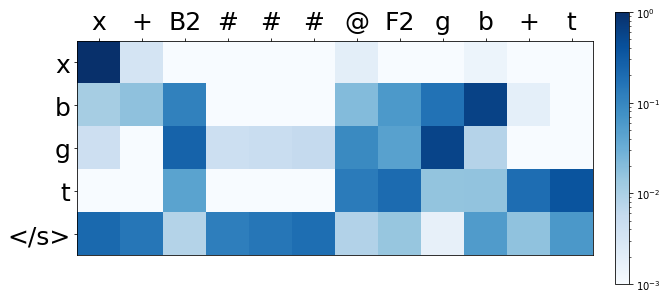

In [ ]:
attention_string = '''x *0.9886827  0.0033117  0.0009440  0.0006621  0.0006968  0.0007958  0.0019709  0.0008666  0.0001488  0.0014559  0.0001113  0.0003533 
         b  0.0111649  0.0172819  0.1150576  0.0008991  0.0006513  0.0008806  0.0209027  0.0601438  0.1691695 *0.6019241  0.0019009  0.0000234 
         g  0.0043469  0.0007787  0.2566831  0.0044932  0.0049268  0.0056731  0.0916061  0.0463853 *0.5762275  0.0081648  0.0006917  0.0000227 
         t  0.0000791  0.0007530  0.0446128  0.0003320  0.0002760  0.0004874  0.1352435  0.2049330  0.0158559  0.0161733  0.1933001 *0.3879538 
      </s> *0.2164626  0.1531711  0.0082663  0.1230459  0.1530814  0.1881004  0.0086251  0.0152142  0.0017405  0.0548019  0.0166286  0.0608619 '''
source_string = 'x + B2 # # # @ F2 g b + t'
target_string = 'x b g t </s>'

attention_matrix = get_mat(attention_string)
plot_attn(attention_matrix, source_string, target_string, (10,5))